 # **IMPORTING Python Libraries**

In [17]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt # graph
import numpy as np
import argparse
import cv2   
import os

# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=True,
#	help="path to input dataset")
#ap.add_argument("-d", "--dataset", default = "C:/Users/KIIT/Downloads/covid19/dataset/") #required=True, help="path to input dataset")
#ap.add_argument("-p", "--plot", type=str, default="C:/Users/KIIT/Downloads/covid19/plot0.png", help="path to output loss/accuracy plot")
#ap.add_argument("-m", "--model", type=str, default="C:/Users/KIIT/Downloads/covid19/",help="path to output loss/accuracy plot")
#args = vars(ap.parse_args())

dataset = "C:/Users/KIIT/Downloads/covid19/dataset/"

   # __Data-Processing__

In [18]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...


In [20]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Visualizing Our Dataset

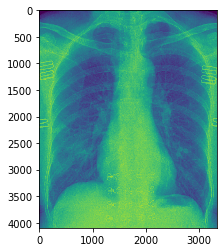

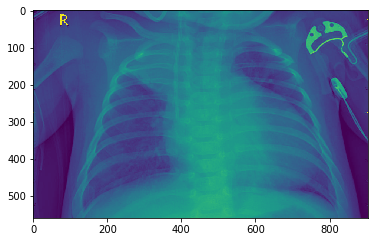

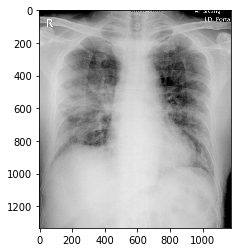

In [3]:
import matplotlib.image as mpimg
import random 
random.shuffle(imagePaths)
for j in imagePaths[0:3]:
    img = mpimg.imread(j)
    imgplot = plt.imshow(img)
    plt.show()

In [4]:
#type(labels)
type(data)
#data

numpy.ndarray

In [5]:
'''import seaborn as sns 
X = np.array(labels)
sns.countplot(X)
'''
print(data.shape)
print(labels.shape)

(50, 224, 224, 3)
(50, 2)


# Building Model and Algorithim

In [7]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3 
EPOCHS = 25
BS = 8
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 5 steps, validate on 10 samples
Epoch 1/25
5/5 [==============================] - 27s 5s/step - loss: 0.9414 - accuracy: 0.5000 - val_loss: 0.5317 - val_accuracy: 0.6250
Epoch 2/25
5/5 [==============================] - 27s 5s/step - loss: 0.7756 - accuracy: 0.5250 - val_loss: 0.5295 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 21s 4s/step - loss: 0.6777 - accuracy: 0.6000 - val_loss: 0.5215 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 19s 4s/step - loss: 0.8613 - accuracy: 0.5000 - val_loss: 0.4824 - val_accuracy: 1.0000
Epoch 5/25
5/5 [==============================] - 23s 5s/step - loss: 0.5669 - accuracy: 0.7000 - val_loss: 0.4743 - val_accuracy: 0.6250
Epoch 6/25
5/5 [==============================] - 23s 5s/step - loss: 0.6694 - accuracy: 0.6250 - val_loss: 0.4678 - 

# Accuracy and Plots

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

[[5 0]
 [0 5]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


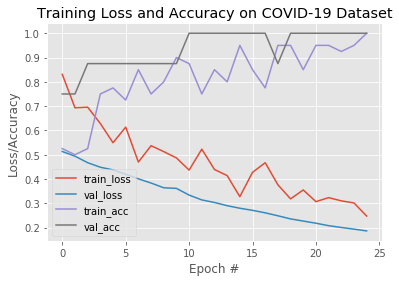

In [7]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [8]:
print("Accuracy : ", acc*100)

Accuracy :  100.0


# Predicting User Given Image 

In [9]:
test_img = "D:/Downloads/Projects/covid-19/keras-covid-19/dataset/test(user)/auntminnie-a-2020_01_coronavirus.jpeg"
test = []
image = cv2.imread(test_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
test.append(image)
test = np.array(test) / 255.0

In [10]:
res = model.predict(test, batch_size=BS)
print(res[0,0])

0.9069443


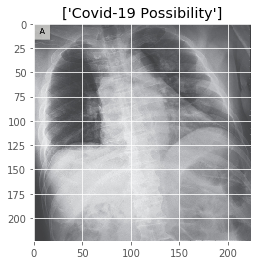

In [11]:
res = model.predict(test, batch_size=BS)
img_label = []
if res[0,0] < 0.5:
    #print("Normal")
    img_label.append("Normal")
else:
    #print("Covid-19 Possibility")
    img_label.append("Covid-19 Possibility")
imgs = cv2.imread(test_img)
imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)
imgs = cv2.resize(imgs, (224, 224))
plt.title(img_label)
imgsplot = plt.imshow(imgs)
plt.show()